## 1. 데이터 가져오기 및 분포 확인

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
raw_df = pd.read_csv('C:/Vegita Project/005930.KS.csv')
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-06,54900.0,55600.0,54600.0,55500.0,49811.800781,10278951
1,2020-01-07,55700.0,56400.0,55600.0,55800.0,50081.035156,10009778
2,2020-01-08,56200.0,57400.0,55900.0,56800.0,50978.554688,23501171
3,2020-01-09,58400.0,58600.0,57400.0,58600.0,52594.070313,24102579
4,2020-01-10,58800.0,59700.0,58300.0,59500.0,53401.835938,16000170


### 주식 가격에 영향을 미친다고 판단이 드는 Column들 선정 후, 그걸 바탕으로 Adj Close값을 예측해보자.
### lstm 이용해서 20년간 주가 데이터 학습한 후, 가장 최근의 1년간 주가를 예측해보고, 실제 주가와의 비교를 통해 
### 과연 lSTM을 통한 주가예측이 얼마나 정확한지 알아보자.

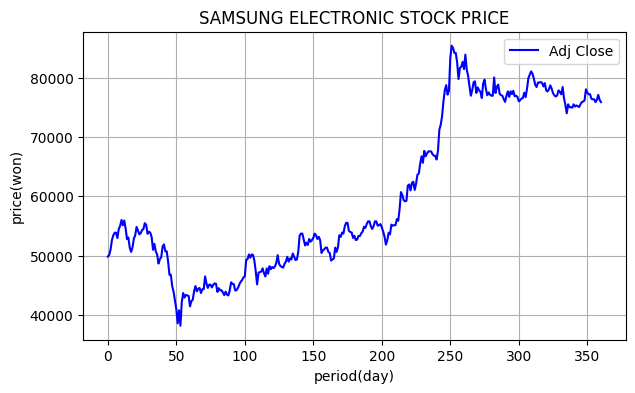

In [4]:
# 분포 확인하기
plt.figure(figsize = (7, 4))
plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price(won)')
plt.xlabel('period(day)')
plt.grid()
# 이제 데이터 추가
plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')
plt.legend(loc = 'best')
# 출력
plt.show()


# 2. 데이터 전처리

### (1) 결측치 제거

In [5]:
# describe 함수를 통해, 통계적으로 데이터 확인해보기
raw_df.describe()
# volume(거래량)의 최소값이 0임을 알 수 있다.  주식같은 금융데이터에서는 0은 missing value 즉, NaN으로 취급하는것이 일반적임
# 해당일이 주말, 공휴일인거지

,Open,High,Low,Close,Adj Close,Volume
count,361.000000,361.000000,361.000000,361.000000,361.000000,3.610000e+02
mean,65399.168975,66123.545706,64723.130194,65392.797784,60238.707389,2.186884e+07
std,13430.116421,13550.079936,13394.567655,13441.242117,13452.402665,9.780706e+06
min,42600.000000,43550.000000,42300.000000,42500.000000,38144.167969,0.000000e+00
25%,54800.000000,55500.000000,54100.000000,54600.000000,49513.867188,1.548994e+07
50%,60200.000000,60500.000000,59500.000000,60000.000000,54478.843750,1.927816e+07
75%,81100.000000,81900.000000,80800.000000,81200.000000,76420.570313,2.541989e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,85433.320313,9.030618e+07


In [6]:
# missing value(결측치) 확인
# missing value는 outlier와 마찬가지로 missing value를 제거하거나, 적절한 값으로 대체하는 등의 처리가  필요함.
# 금융 데이터에서는 NaN으로 표시되는 missing value는 평균값 or 중간값으로의 대체보다는 행 전체를 삭제하는 것이 일반적
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
# 최솟값이 0인 열이 있는지 확인
for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [8]:
# 최솟값이 0인 열의 행 출력
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume
43,2020-03-09,56500.0,56500.0,56500.0,56500.0,50709.300781,0
46,2020-03-12,52100.0,52100.0,52100.0,52100.0,46760.261719,0


In [9]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 2


In [10]:
# 결측치 처리해주기. Volume값의 0을 모두 NaN으로 대체
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# NaN으로 바꾼 후, 각 column에 0이 몇개인지 다시 확인보기. 
for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0


In [11]:
# missing data 확인.  결측치. NaN값. 
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       2
dtype: int64

In [12]:
# 결측치 삭제하고 개수 확인
raw_df = raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### (2) 정규화

In [13]:
# 딥러닝 학습을 위해선, 정규화 작업이 필요. 즉, 날짜를 나타내는 date항목을 제외한
# 숫자로 표현되는 모든 column에 대해서 0~1로 정규화를 수행함.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 정규화 해줄 열 지정
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
# 정규화
scaled_df = scaler.fit_transform(raw_df[scale_cols])
# numpy형태로 리턴된 것을 다시 pandas형태로 바꿔줌
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

         Open      High       Low     Close  Adj Close    Volume
0    0.257862  0.226291  0.260593  0.268041   0.246730  0.018860
1    0.274633  0.241315  0.281780  0.274227   0.252423  0.015560
2    0.285115  0.260094  0.288136  0.294845   0.271402  0.180966
3    0.331237  0.282629  0.319915  0.331959   0.305565  0.188339
4    0.339623  0.303286  0.338983  0.350515   0.322646  0.089003
..        ...       ...       ...       ...        ...       ...
354  0.800839  0.701408  0.809322  0.783505   0.798646  0.022184
355  0.802935  0.707042  0.811441  0.791753   0.806623  0.016368
356  0.815514  0.720188  0.822034  0.810309   0.824570  0.076739
357  0.807128  0.708920  0.813559  0.791753   0.806623  0.064571
358  0.807128  0.705164  0.809322  0.783505   0.798646  0.075720

[359 rows x 6 columns]


### (3) feature column / label column 정의

In [17]:
# 딥러닝 학습을 위한 입력데이터 feature column, 정답데이터 label column 정의 후, numpy로 변환하여, 전처리과정 완료
# feature column은 근데 어떻게 정하나???

# feature_df, label_df 생성

feature_cols = [ 'Open', 'Close', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [15]:
# DataFrame => Numpy 변환  딥러닝을 위해.

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(359, 3) (359, 1)


# 3. 시계열 데이터 생성

### (1) window size 설정 및 feature_np, label_np, window size 바탕으로 학습데이터 X, Y 생성

In [18]:
window_size = 40

def make_sequene_dataset(feature, label, window_size):  # numpy type이 들어와야함.

    feature_list = []      # 입력데이터 저장할 리스트
    label_list = []        # 정답데이터 저장할 리스트

    for i in range(len(feature)-window_size):    

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)   # 3차원 tensor형태로 return 
    
X, Y = make_sequene_dataset(feature_np, label_np, window_size)
print(X.shape, Y.shape)    # (batch size, time steps, input dims) 형태의 3차원 tensor 형성됨.

(319, 40, 3) (319, 1)


### (2) 훈련 데이터, 테스트 데이터 생성

In [22]:
# 가장 최근의 데이터 20개를 테스트 데이터로 넣기로 선정

split = -20

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(299, 40, 3) (299, 1)
(20, 40, 3) (20, 1)


# 4. 모델 구축 및 학습

### (1) 모델 구축 및 컴파일

In [30]:
model = Sequential()
# 128개의 노드를 가지는 lSTM layer(은닉층)과   (input은 (40, 3))
model.add(LSTM(18, activation='tanh', input_shape=x_train[0].shape))
# 1개의 노드를 가지는 출력층으로 구성된 모델을 구축
model.add(Dense(1, activation='linear'))

In [31]:
model.compile(loss='mse', optimizer='adam', metrics=['mae']) # mae : 오차절댓값
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 18)                  │           1,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603 (6.26 KB)

 Trainable params: 1,603 (6.26 KB)

 Non-trainable params: 0 (0.00 B)

### (2) 모델 학습 (EarlyStopping 적용)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
# 조기종료를 위한 조건
early_stop = EarlyStopping(monitor='val_loss', patience=5)    # 손실함수가 더이상 줄지 않으면 이 조건에 의해 조기종료

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,           # 100번을 반복해보겠다.  손실함수가 지속적으로 작아지는게 확인됨. 
          callbacks=[early_stop])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.3197 - mae: 0.4623 - val_loss: 0.1098 - val_mae: 0.3305
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0321 - mae: 0.1411 - val_loss: 7.4483e-04 - val_mae: 0.0254
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - mae: 0.0988 - val_loss: 0.0055 - val_mae: 0.0730
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0622 - val_loss: 2.5009e-04 - val_mae: 0.0149
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0455 - val_loss: 2.2530e-04 - val_mae: 0.0133
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0340 - val_loss: 5.9699e-04 - val_mae: 0.0223
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mae: 0.0349 - val_loss: 4.3783e-04 - val_mae: 0.0194
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0363 - val_loss: 6.8056e-04 - val_mae: 0.0237
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 

### (3) 예측을 통한 정답과의 비교 (오차계산 MAPE 사용, 평균절대값백분율오차)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


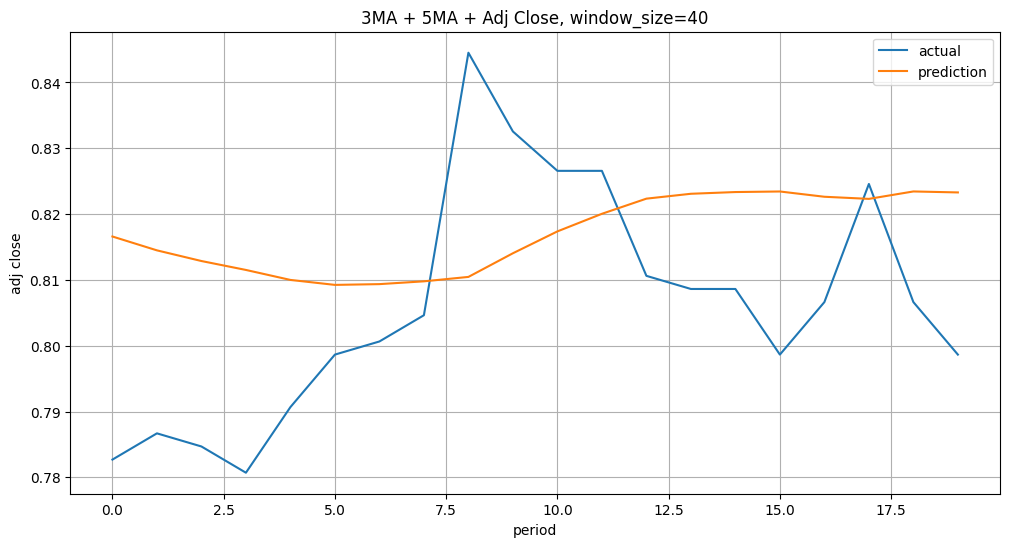

In [33]:
# 테스트 data에 대해서, lstm모델이 실제 모델을 얼마나 잘 예측하는가 
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()   # 개판이네??